The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.14.4

# Sequence Models

### Autoregressive Models


## Training

We begin by generating some data.
To keep things simple we generate our sequence data by using a sine function with some additive noise for time steps $1, 2, \ldots, 1000$.


In [90]:
%matplotlib inline
from d2l import torch as d2l
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np

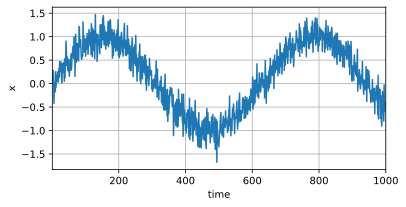

In [91]:
T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
#x = torch.sin(0.01 * time) 
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

Next, we need to turn such a sequence into features and labels that our model can train on.
Based on the embedding dimension $\tau$ we map the data into pairs $y_t = x_t$ and $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$.
The astute reader might have noticed that this gives us $\tau$ fewer data examples, since we do not have sufficient history for the first $\tau$ of them.
A simple fix, in particular if the sequence is long,
is to discard those few terms.
Alternatively we could pad the sequence with zeros.
Here we only use the first 600 feature-label pairs for training.


In [92]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].view(-1, 1)

In [93]:
batch_size, n_train = 16, 600
from torch.utils import data
train_dataset = data.TensorDataset(features[:n_train], labels[:n_train])
train_loader= torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=4)

Here we keep the architecture fairly simple:
just an MLP with two fully-connected layers, ReLU activation, and square loss.


In [94]:
# Function for initializing the weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

# A simple MLP
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net


In [95]:
### Define simple RNN
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        nonlinearity='relu',
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M)

    # get RNN unit output
    # out is of size (N, sequence_length, M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, h0)

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out

In [96]:
# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)

In [97]:
epochs =5
lr= 0.01

In [98]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

# TRAIN THE MODEL

train_losses= np.zeros(epochs)

for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for input,targets in train_loader:
     
    input= input.view(-1,tau,1)
    # forward pass
    output= model(input)
    loss=criterion(output,targets)

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      

  # save Losses
  train_losses[epoch]= train_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f} , Duration: {dt}')


Epoch 1/5, Train Loss: 0.2164 , Duration: 0:00:00.160263
Epoch 2/5, Train Loss: 0.0676 , Duration: 0:00:00.133218
Epoch 3/5, Train Loss: 0.0654 , Duration: 0:00:00.132930
Epoch 4/5, Train Loss: 0.0655 , Duration: 0:00:00.128844
Epoch 5/5, Train Loss: 0.0611 , Duration: 0:00:00.142699


## Prediction

Since the training loss is small, we would expect our model to work well. Let us see what this means in practice. The first thing to check is how well the model is able to predict what happens just in the next time step,
namely the *one-step-ahead prediction*.


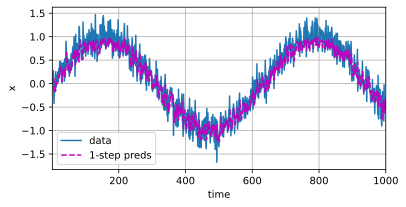

In [99]:
 with torch.no_grad():
  onestep_preds = model(features.view(-1,tau,1))
  d2l.plot([time, time[tau:]], [d2l.numpy(x), d2l.numpy(onestep_preds)], 'time',
          'x', legend=['data', '1-step preds'], xlim=[1, 1000],
          figsize=(6, 3))

The one-step-ahead predictions look nice, just as we expected.
Even beyond 604 (`n_train + tau`) observations the predictions still look trustworthy.
However, there is just one little problem to this:
if we observe sequence data only until time step 604, we cannot hope to receive the inputs for all the future one-step-ahead predictions.
Instead, we need to work our way forward one step at a time:

$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

Generally, for an observed sequence up to $x_t$, its predicted output $\hat{x}_{t+k}$ at time step $t+k$ is called the *$k$-step-ahead prediction*. Since we have observed up to $x_{604}$, its $k$-step-ahead prediction is $\hat{x}_{604+k}$.
In other words, we will have to use our own predictions to make multistep-ahead predictions.
Let us see how well this goes.


In [100]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = d2l.reshape(model(
        multistep_preds[i - tau: i].view(-1,tau,1)), 1)

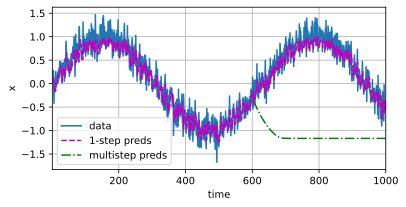

In [101]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [d2l.numpy(x), d2l.numpy(onestep_preds),
          d2l.numpy(multistep_preds[n_train + tau:])], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

As the above example shows, this is a spectacular failure. The predictions decay to a constant pretty quickly after a few prediction steps.
Why did the algorithm work so poorly?
This is ultimately due to the fact that the errors build up.
Let us say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$.
Now the *input* for step 2 is perturbed by $\epsilon_1$, hence we suffer some error in the order of $\epsilon_2 = \bar\epsilon + c \epsilon_1$ for some constant $c$, and so on. The error can diverge rather rapidly from the true observations. This is a common phenomenon. For instance, weather forecasts for the next 24 hours tend to be pretty accurate but beyond that the accuracy declines rapidly. We will discuss methods for improving this throughout this chapter and beyond.

Let us take a closer look at the difficulties in $k$-step-ahead predictions
by computing predictions on the entire sequence for $k = 1, 4, 16, 64$.


In [102]:
max_steps = 64

In [103]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1].T

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = d2l.reshape(model(features[:, i - tau: i].view(-1,tau,1)), -1)

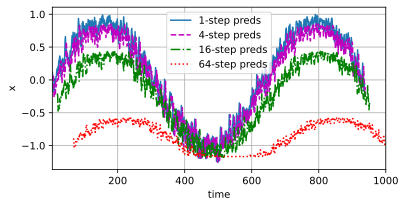

In [104]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [d2l.numpy(features[:, tau + i - 1]) for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

This clearly illustrates how the quality of the prediction changes as we try to predict further into the future.
While the 4-step-ahead predictions still look good, anything beyond that is almost useless.


## Summary

* There is quite a difference in difficulty between interpolation and extrapolation. Consequently, if you have a sequence, always respect the temporal order of the data when training, i.e., never train on future data.
* Sequence models require specialized statistical tools for estimation. Two popular choices are autoregressive models and latent-variable autoregressive models.
* For causal models (e.g., time going forward), estimating the forward direction is typically a lot easier than the reverse direction.
* For an observed sequence up to time step $t$, its predicted output at time step $t+k$ is the *$k$-step-ahead prediction*. As we predict further in time by increasing $k$, the errors accumulate and the quality of the prediction degrades, often dramatically.



